<a href="https://colab.research.google.com/github/lorenzobalzani/nlp_projects/blob/master/Assignment1/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP - Assignment 1

Lorenzo Balzani, Alessia Deana, Thomas Guizzetti

lorenzo.balzani@studio.unibo.it, alessia.deana@studio.unibo.it, thomas.guizzetti@studio.unibo.it

# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: POS tagging, Sequence labelling, RNNs


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the task of POS tagging.

<center>
    <img src="https://github.com/lorenzobalzani/nlp_assigments/blob/master/Assignment1/images/pos_tagging.png?raw=1" alt="POS tagging" />
</center>

# [Task 1 - 0.5 points] Corpus

You are going to work with the [Penn TreeBank corpus](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

**Ignore** the numeric value in the third column, use **only** the words/symbols and their POS label.

### Example

```Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8
```

### Splits

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199

### Instructions

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

In [35]:
%%capture
%pip install wget gensim prettytable
%pip install cudf-cu11 --extra-index-url=https://pypi.nvidia.com
%pip install gdown==4.6.0


import os
import wget
from zipfile import ZipFile
from typing import List, Dict, Tuple, Any
import hashlib
from prettytable import PrettyTable
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score
from collections import Counter
import gensim
import gensim.downloader as gensim_downloader
from google.colab import drive
import random
import matplotlib.pyplot as plt
import gdown
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [2]:
def create_dataframe_and_split(download_dataset: bool = False, folder_path: str = "dependency_treebank") -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    dataframe: List[Dict[str, str]] = list()
    dataset_filename: str = f"{folder_path}.zip"
    if download_dataset and not os.path.exists(dataset_filename):
      wget.download("https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip")
      with ZipFile(dataset_filename, "r") as zObject:
        zObject.extractall()

    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        dp_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.dp')])

        for dp_file in dp_files:
            with open(os.path.join(folder_path, dp_file), 'r') as file:
                for line in file.readlines():
                    line = line.split("\t")[:-1]
                    if len(line) > 0: # some lines can be empty
                        dataframe.append({"value": line[0], "pos_label": line[1], "doc_idx": int(dp_file.split("_")[-1].split(".")[0])})

    else:
        print("The specified folder does not exist or is not a directory.")
    df: pd.DataFrame = pd.DataFrame.from_dict(dataframe)
    train: pd.DataFrame = df[df["doc_idx"] <= 100]
    validation: pd.DataFrame = df[(df["doc_idx"] > 100) & (df["doc_idx"] <= 150)]
    test: pd.DataFrame = df[(df["doc_idx"] > 150) & (df["doc_idx"] <= 199)]
    return train, validation, test

train, validation, test = create_dataframe_and_split(download_dataset = True)

# Test
print(f"Check on training set:", all(train["doc_idx"] <= 100))
print(f"Check on validation set:", all((validation["doc_idx"] > 100) & (validation["doc_idx"] <= 150)))
print(f"Check on validation set:", all((test["doc_idx"] > 150) & (test["doc_idx"] <= 199)))

Check on training set: True
Check on validation set: True
Check on validation set: True


# [Task 2 - 0.5 points] Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.

## Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

In [3]:
def load_embedding_model(model_type: str, embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    try:
        emb_model = gensim_downloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [4]:
embedding_dim = 300
model_type = "glove"
embedding_filename = f"{model_type}_{embedding_dim}_embeddings.pt"

try:
  print(f"Attempting to download {embedding_filename} from Drive...")
  file_id = '1CnoH7tB-1v-1J_Qf2WVelew6wY7RTOd7'
  url = f'https://drive.google.com/uc?id={file_id}'
  gdown.download(url, embedding_filename, quiet=False)
  embedding_model = torch.load(embedding_filename)
  print(f"Successfully downloaded {embedding_filename} from Drive!")
except: # Load and save the model if it doesn't exist
    print("Loading embedding model...")
    embedding_model = load_embedding_model(model_type=model_type, embedding_dimension=embedding_dim)
    torch.save(embedding_model, embedding_filename)

Attempting to download glove_300_embeddings.pt from Drive...
Access denied with the following error:
Loading embedding model...



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1CnoH7tB-1v-1J_Qf2WVelew6wY7RTOd7 



[==================================================] 100.0% 376.1/376.1MB downloaded


### Check OOV words

In [5]:
def check_oov_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

#### No pre-processing

In [6]:
oov_terms = check_oov_terms(embedding_model, train['value'].unique())
oov_percentage = float(len(oov_terms)) / len(train['value'].unique())
print(f"Total OOV terms in the train set: {len(oov_terms)} ({oov_percentage:.2%})")

Total OOV terms in the train set: 2346 (29.29%)


#### Applying lower()

In [7]:
train['value'] = train['value'].str.lower()
validation['value'] = validation['value'].str.lower()
test['value'] = test['value'].str.lower()
oov_terms_lowercase = check_oov_terms(embedding_model, train['value'])
oov_terms_lowercase_percentage = float(len(oov_terms_lowercase)) / len(train['value'].unique())
print(f"Total OOV terms in the train set after applying lowercase method: {len(oov_terms_lowercase)} ({oov_terms_lowercase_percentage:.2%})")

Total OOV terms in the train set after applying lowercase method: 359 (4.85%)


#### Lemmatization

In [8]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def convert_pos_tags(pos_tag: str) -> str:
    mapping = {
        "CC": wordnet.NOUN,
        "CD": wordnet.NOUN,
        "DT": wordnet.NOUN,
        "EX": wordnet.NOUN,
        "FW": wordnet.NOUN,
        "IN": wordnet.NOUN,
        "JJ": wordnet.ADJ,
        "JJR": wordnet.ADJ,
        "JJS": wordnet.ADJ,
        "LS": wordnet.NOUN,
        "MD": wordnet.VERB,
        "NN": wordnet.NOUN,
        "NNS": wordnet.NOUN,
        "NNP": wordnet.NOUN,
        "NNPS": wordnet.NOUN,
        "PDT": wordnet.ADJ,
        "POS": wordnet.NOUN,
        "PRP": wordnet.NOUN,
        "PRP$": wordnet.NOUN,
        "RB": wordnet.ADV,
        "RBR": wordnet.ADV,
        "RBS": wordnet.ADV,
        "RP": wordnet.NOUN,
        "SYM": wordnet.NOUN,
        "TO": wordnet.NOUN,
        "UH": wordnet.NOUN,
        "VB": wordnet.VERB,
        "VBD": wordnet.VERB,
        "VBG": wordnet.VERB,
        "VBN": wordnet.VERB,
        "VBP": wordnet.VERB,
        "VBZ": wordnet.VERB,
        "WDT": wordnet.NOUN,
        "WP": wordnet.NOUN,
        "WP$": wordnet.NOUN,
        "WRB": wordnet.ADV
    }

    return mapping.get(pos_tag)


def lemmatize_dataset(word: str, pos_label: str = None) -> str:
    try:
      lemma: str = lemmatizer.lemmatize(word, convert_pos_tags(pos_label))
      return lemma
    except Exception as e:
      return word

train_lemmatize = train.copy(deep=True)
validation_lemmatize = train.copy(deep=True)
test_lemmatize = train.copy(deep=True)

train_lemmatize['value'] = train_lemmatize.apply(lambda row: lemmatize_dataset(row['value'], row['pos_label']), axis=1)
validation_lemmatize['value'] = validation_lemmatize.apply(lambda row: lemmatize_dataset(row['value']), axis=1)
test_lemmatize['value'] = test_lemmatize.apply(lambda row: lemmatize_dataset(row['value']), axis=1)

oov_terms_lemmatization = check_oov_terms(embedding_model, train_lemmatize['value'].unique())
oov_percentage_lemmatization = float(len(oov_terms_lemmatization)) / len(train_lemmatize['value'].unique())
print(f"Total OOV terms in the train set: {len(oov_terms_lemmatization)} ({oov_percentage_lemmatization:.2%})")

Total OOV terms in the train set: 363 (6.00%)


Lemmatizing words in a pre-processing pipeline for extracting Part-of-Speech (POS) tags may not always be beneficial and can inadvertently lead to an increase in out-of-vocabulary (OOV) instances. Lemmatization involves reducing words to their base or root form which could not be beneficial when aiming to extract POS tags, since preserving the original word forms may be more advantageous. This transformation can introduce ambiguity and misclassification, especially caused by the loss of distinct syntactic information crucial for accurate POS tagging.

We notive that uppercase/capitalized words are for the most part not present in the Glove embedding. After some experimentation, we realised that applying a `lower()` method to the dataset increases the number of unique embeddings in our models, resulting in an higher f1-score. Furthermore, we also notice more words not present in the Glove embedding of type as below:

* Numerical Values and Quantities: These are numbers often used in financial, scientific, or statist`cal contexts. They can be whole numbers, decimals, or even fractions. Examples include '1.457', '100,980', '12,252', and '1\/10th'.

* Alphanumeric Combinations: These are words that combine numbers and letters, often used in specific technical or branded contexts. Examples include 'c-90', 'c.j.b.', and 'ctbs'.

* Composite Words or Compound Words: These are words formed by combining two or more words, often linked by hyphens. They are used to create a specific or more nuanced meaning than the individual words alone. Examples include 'asset-sale', 'auto-safety', 'beer-belly', 'capital-gains', 'computer-system-design', and 'family-planning'.

* Bracket Representations: Words like '-lcb-', '-lrb-', '-rcb-', and '-rrb-' are likely placeholders or encoded representations for left and right brackets (curly and round), often used in text processing or encoding.

* Branded or Specific Names: These include names that might be specific to companies, brands, models, or even specific terms within an industry. Examples include 'bridgestone/firestone', 'corton-charlemagne', 'akerfeldt', and 'aslacton'.

* Mixture of Alphabetic and Symbolic Characters: Some entries combine letters with symbols, such as 'creator's' and 'delwin'. These may represent possessive forms or be specific names or terms with an apostrophe.

* Hyphenated Descriptive Terms: These are descriptive phrases often hyphenated to express a specific idea or concept, like 'big-ticket', 'bald-faced', and 'dead-eyed'.

* Technical or Industry-Specific Terms: Some words seem to be specific to certain fields or industries, like 'crocidolite' (a type of asbestos), 'amphobiles', and 'antitrust-law'.

In [9]:
set(oov_terms_lowercase) - set(oov_terms)

{'-lcb-',
 '-lrb-',
 '-rcb-',
 '-rrb-',
 'ac-130u',
 'akerfeldt',
 'alurralde',
 'anti-china',
 'ariail',
 'aslacton',
 'bermuda-based',
 'biondi-santi',
 'boorse',
 'bridgestone\\/firestone',
 'bumkins',
 'c-90',
 'c.j.b.',
 'centerbank',
 'chafic',
 'chemplus',
 'chilver',
 'chinchon',
 'chong-sik',
 'coche-dury',
 'colonsville',
 'corton-charlemagne',
 'cotran',
 'cray-3',
 "creator's",
 'ctbs',
 'delwin',
 'deposits-a',
 'derel',
 'dollar-yen',
 'drobnick',
 'ensrud',
 'erbamont',
 'ft-se',
 'ghkm',
 'gingl',
 'glenham',
 'hallwood',
 'hummerstone',
 'ingersoll-rand',
 'integra-a',
 'iran\\/contra',
 'jalaalwalikraam',
 'jerritts',
 'kalipharma',
 'lafite-rothschild',
 'landonne',
 'lezovich',
 'macheski',
 'macmillan\\/mcgraw',
 'macmillan\\/mcgraw-hill',
 'makato',
 'malizia',
 'mehrens',
 'meinders',
 'micronite',
 'moleculon',
 'monchecourt',
 'muscolina',
 'nagymaros',
 'nekoosa',
 'nesb',
 'nih-appointed',
 'nipponese',
 'nissho-iwai',
 'northy',
 'norwick',
 'ntg',
 'old-hou

# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

In [10]:
 # SoftMax is not necessary when using cross-entropy in Pytorch

class BaselineModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, embedding_matrix, padding_idx):
        super(BaselineModel, self).__init__()

        # Embedding layer with pre-trained weights
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx).from_pretrained(embedding_matrix, freeze=False)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)

        # Dense layer
        self.linear = nn.Linear(hidden_size * 2, num_classes)  # Multiply by 2 for bidirectional

        # Potential softmax layer -> self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        hidden_vectors, _ = self.lstm(x)
        x = self.linear(hidden_vectors)
        return x


class Model1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, embedding_matrix, padding_idx):
        super(Model1, self).__init__()

        # Embedding layer with pre-trained weights
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx).from_pretrained(embedding_matrix, freeze=False)

        # Two layers of Bidirectional LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True, num_layers=2)

        # Dense layer
        self.linear = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        hidden_vectors, _ = self.lstm(x)
        x = self.linear(hidden_vectors)
        return x


class Model2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, embedding_matrix, padding_idx):
        super(Model2, self).__init__()

        # Embedding layer with pre-trained weights
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx).from_pretrained(embedding_matrix, freeze=False)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)

        # Dense layer
        self.linear1 = nn.Linear(hidden_size * 2, hidden_size * 2)

        # Dense layer
        self.linear2 = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        hidden_vectors, _ = self.lstm(x)
        x = self.linear1(hidden_vectors)
        x = self.linear2(x)
        return x

Let's create an embedding using the pre-trained Glove Embedding for each word in our vocabulary. If the word is OOV, we will instantiate an embedding that only consists of zeros.

If the input word is unknown <UNK> the embedding result is always the same.

In [11]:
def get_word_embedding(embedding_model, word: str, embedding_dim: int, random_seed: int = 42) -> np.ndarray:
    np.random.seed(random_seed)

    if word == '<PAD>':
        return np.zeros(embedding_dim)
    elif word == '<UNK>':
        return generate_consistent_random_embedding(word, embedding_dim)
    else:
        try:
            return embedding_model[word]
        except KeyError:
            return generate_consistent_random_embedding(word, embedding_dim)

def generate_consistent_random_embedding(word: str, embedding_dim: int) -> np.ndarray:
    # Use a hash function to generate a unique number for the word
    hash_value = int(hashlib.sha256(word.encode('utf-8')).hexdigest(), 16)
    np.random.seed(hash_value % (2**32 - 1))  # Use the hash value as a seed

    return np.random.uniform(low=-1, high=1, size=embedding_dim)

def pad_sequences(sequences, max_length, padding_idx=0):
    # Convert sequences to tensor
    sequence_tensors = [torch.tensor(sequence) for sequence in sequences]

    # Pad each sequence to the maximum length
    padded_sequences = [torch.nn.functional.pad(seq, (0, max_length - len(seq)), 'constant', padding_idx) for seq in sequence_tensors]

    # Stack the sequences into a single tensor
    padded_sequences = torch.stack(padded_sequences)

    return padded_sequences

def features_tokenizer(sorted_vocabulary: pd.Series, words: pd.Series) -> pd.Series:
    word_to_index = {word: i for i, word in enumerate(sorted_vocabulary)}

    def tokenize_single_word(word):
        return word_to_index.get(word, word_to_index["<UNK>"]) # If word is not in dictionary, it returns default "word_to_index[<UNK>]"

    return words.apply(tokenize_single_word)

def labels_tokenizer(sorted_vocabulary: pd.Series, words: pd.Series) -> pd.Series:
    word_to_index = {word: i for i, word in enumerate(sorted_vocabulary)}

    def tokenize_single_word(word):
        return word_to_index[word]

    return words.apply(tokenize_single_word)

In [12]:
# Sorting out our vocabulary train in alphabetical order, after having dropped duplicates
vocabulary = train['value'].drop_duplicates().sort_values()

print(f"Is <UNK> already in the vocabulary?: {'<UNK>' in train['value'].drop_duplicates().sort_values()}")
print(f"Is <PAD> already in the vocabulary?: {'<PAD>' in train['value'].drop_duplicates().sort_values()}")

# Add padding token
features_vocabulary = pd.concat([pd.Series(["<PAD>"]), pd.Series(["<UNK>"]), vocabulary]).reset_index(drop=True)
features_vocabulary_size = len(features_vocabulary)
print(f"\nSize of the vocabulary is {features_vocabulary_size}")

labels_vocabulary = train['pos_label'].drop_duplicates().sort_values().reset_index(drop=True)
labels_vocabulary_size = len(labels_vocabulary)
print(f"Size of the POS target set is {labels_vocabulary_size}")

word_to_embedding = {word: get_word_embedding(embedding_model, word, embedding_dim, 42) for i, word in enumerate(features_vocabulary)}

embedding_matrix = np.vstack(list(word_to_embedding.values()))

# Create PyTorch tensor to use in models
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

Is <UNK> already in the vocabulary?: False
Is <PAD> already in the vocabulary?: False

Size of the vocabulary is 7406
Size of the POS target set is 45


In [13]:
def split_into_sentences(df):
    # Identify the end of sentences (rows where 'value' is '.')
    sentence_end_mask = df['value'] == '.'

    # Shift the mask by one row so that the period is included in the current sentence
    shifted_sentence_end_mask = sentence_end_mask.shift(1, fill_value=False)

    # Add an extra column for sentence indices
    df['sentence_idx'] = shifted_sentence_end_mask.cumsum()

    # Split the dataframe into a list of dataframes, each representing a sentence
    sentences = [sentence_df for _, sentence_df in df.groupby('sentence_idx')]

    return pd.concat(sentences)

# Usage
train_with_sentences = split_into_sentences(train)
validation_with_sentences = split_into_sentences(validation)
test_with_sentences = split_into_sentences(test)

train_with_sentences.head()

,value,pos_label,doc_idx,sentence_idx
0,pierre,NNP,1,0
1,vinken,NNP,1,0
2,",",",",1,0
3,61,CD,1,0
4,years,NNS,1,0


In [14]:
train_padding_max_length = 0
for sentence_idx in train_with_sentences['sentence_idx'].unique():
  train_padding_max_length = max(sum(train_with_sentences['sentence_idx'] == sentence_idx), train_padding_max_length)

print(f"The maximum length of a document in training set is {train_padding_max_length}")

validation_padding_max_length = 0
for sentence_idx in validation_with_sentences['sentence_idx'].unique():
  validation_padding_max_length = max(sum(validation_with_sentences['sentence_idx'] == sentence_idx), validation_padding_max_length)
print(f"The maximum length of a document in validation set is {validation_padding_max_length}")

test_padding_max_length = 0
for sentence_idx in test_with_sentences['sentence_idx'].unique():
  test_padding_max_length = max(sum(test_with_sentences['sentence_idx'] == sentence_idx), test_padding_max_length)
print(f"The maximum length of a document in test set is {test_padding_max_length}")

The maximum length of a document in training set is 250
The maximum length of a document in validation set is 88
The maximum length of a document in test set is 80


We define a function to generate x and y splits for our train, validation and test set as below. In particular, the input of our function will be:

* dataframe_list: a list of the dataframes we need to split, in our case train, validation and test.
* padding_max_length: the maximum lenght of our padded sequences
* features_vovabulary: vocabulary of our features
* labels_vovabulary: vocabulary of our labels

In [15]:
def train_test_val_splits(dataframe_list: List[pd.DataFrame], padding_max_length: int, features_vocabulary: pd.Series, labels_vocabulary: pd.Series) -> Tuple[torch.Tensor, ...]:
    padded_data = list()

    for dataframe in dataframe_list:
        # Map words and POS labels to indices
        dataframe['word_token'] = features_tokenizer(features_vocabulary, dataframe['value'])
        dataframe['pos_token'] = labels_tokenizer(labels_vocabulary, dataframe['pos_label'])

        # Group by document index and aggregate as lists
        grouped_per_doc = dataframe.groupby('sentence_idx').agg(list)

        # Extract and pad sequences
        x_padded = pad_sequences(grouped_per_doc['word_token'].tolist(), padding_max_length)
        y_padded = pad_sequences(grouped_per_doc['pos_token'].tolist(), padding_max_length)

        padded_data.append((x_padded, y_padded))

    # Unpack the padded data for train, validation, and test sets
    x_train, y_train = padded_data[0]
    x_val, y_val = padded_data[1]
    x_test, y_test = padded_data[2]

    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = train_test_val_splits([train_with_sentences, validation_with_sentences, test_with_sentences], max(train_padding_max_length, validation_padding_max_length), features_vocabulary, labels_vocabulary)

# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe are **not** considered as OOV
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)

In [16]:
def compute_f1(model, x: torch.Tensor, y: torch.Tensor) -> float:

  def remove_punctuation_and_symbols(y: torch.Tensor, preds: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    indices = [idx for idx, token in enumerate(y) if labels_vocabulary[token.item()].isalnum()]
    return y[indices], preds[indices]

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  preds = infer(model, x, device).cpu()

  y, preds = remove_punctuation_and_symbols(y.flatten(), preds.flatten())

  return f1_score(y, preds, average="macro")

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

In [17]:
def training_model(model, train_dataloader, val_dataloader, num_epochs, loss_func, optimizer, device, patience, min_delta) -> Tuple[float, List[float]]:
    total_steps = len(train_dataloader)
    best_val_loss = float('inf')
    all_loss: List[float] = list()
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0

        for batch_idx, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            output = model(inputs)
            output = output.view(-1, output.shape[-1])
            labels = labels.view(-1)

            # Loss calculation and backpropagation
            loss = loss_func(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / total_steps

        # Validation Phase
        model.eval()
        f1_score_val: float = compute_f1(model, x_val, y_val)
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                output = model(inputs)
                output = output.view(-1, output.shape[-1])
                labels = labels.view(-1)

                # Loss calculation
                loss = loss_func(output, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        all_loss.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation F1-score: {f1_score_val:.2%}")

        # Early Stopping Check
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered. Stopping training after {epoch+1} epochs.')
                break
    return f1_score_val, all_loss

In [18]:
def infer(model, input_document, device: str):
    model.eval()
    with torch.no_grad():
        output = model(input_document.to(device))
        predictions = torch.argmax(output, dim=-1)  # Get the index of the max log-probability
    return predictions

In [40]:
import urllib.request

def download_model(model_name, file_id):
    url = f'https://drive.google.com/uc?id={file_id}'
    output = f"{model_name}.pt"
    if not os.path.exists(output):
        urllib.request.urlretrieve(url, output)
    return torch.load(output, map_location=torch.device('cpu'))


def download_table(table_name, file_id):
    url = f'https://drive.google.com/uc?id={file_id}'
    output = f"{table_name}.csv"
    if not os.path.exists(output):
        urllib.request.urlretrieve(url, output)
    return pd.read_csv(output)


In [41]:
model_urls = {
    "BaselineModel_42": "1UZ1nVYWqs3IGioEwK0huBnYYw0XKLbQR",
    "Model1_42": "1FfrxWF5-Qnm3lMpm3xZNIepumlzYXg2-",
    "Model2_42": "1_Fev2Viwg1_XLwqU206wLnGI7mfTtYuG",
    "BaselineModel_1024": "1EVCVQ1Uy-95XMJ9r0REbPNGZU9fZCK5f",
    "Model1_1024": "1qMJV-9Du0ZMMxSOtTBlzRI-BYaewaJro",
    "Model2_1024": "13Qp98AiyEg8P1dpD0jxt5Fj6Jms5vOfD",
    "BaselineModel_4096": "1GMgey95wN6JIyKQ2xvZVdT7uKNFRKwkq",
    "Model1_4096": "194opT3xs6qVJTFXrR91fGyJaQ9u-Pc4d",
    "Model2_4096": "1fb3OxGiXISiUvyhA3DPnsGTKJvOe5jPE",
}

train_models = False
seeds: List[int] = [42, 1024, 4096]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_func = nn.CrossEntropyLoss()
epochs: int = 100
train_batch_size: int = 32
val_batch_size: int = 32
lr: float = 1e-4
padding_idx: int = 0
patience: int = 100
min_delta: float = 1e-3

if train_models == False:
    models_data_file_id = '1YC28hDvB7-gBe3DP9zNK63ME04rGTOMC'
    csv_filename = 'models_data.csv'
    models_data = download_table(csv_filename, models_data_file_id)
    models_data['model_name'] = pd.Series(model_urls.keys())
    models_data['model_url'] = pd.Series(model_urls.values())
    pre_trained_models = {model: np.nan for model in model_urls.keys()}

    for seed in seeds:
      if seed is not None:
          torch.manual_seed(seed)
          np.random.seed(seed)
          random.seed(seed)
          if torch.cuda.is_available():
              torch.cuda.manual_seed_all(seed)

      # Create a TensorDataset and DataLoader for training data
      train_dataset = TensorDataset(x_train, y_train)
      train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

      # BaselineModel
      baseline_model_name = f"BaselineModel_{seed}"
      if baseline_model_name in model_urls:
          print(f"Attempting to download {baseline_model_name}...")
          baseline_model = download_model(baseline_model_name, model_urls[baseline_model_name])
          print(f"Successfully downloaded {baseline_model_name}!")
          pre_trained_models[baseline_model_name] = baseline_model

      # BaselineModel
      model1_name = f"Model1_{seed}"
      if model1_name in model_urls:
          print(f"Attempting to download {baseline_model_name}...")
          model_1 = download_model(model1_name, model_urls[model1_name])
          print(f"Successfully downloaded {baseline_model_name}!")
          pre_trained_models[model1_name] = model_1

      # BaselineModel
      model2_name = f"Model2{seed}"
      if model2_name in model_urls:
          print(f"Attempting to download {model2_name}...")
          model_2 = download_model(model2_name, model_urls[model2_name])
          print(f"Successfully downloaded {baseline_model_name}!")
          pre_trained_models[model2_name] = model_2

    best_model_name = models_data[models_data['f1_score'] == models_data['f1_score'].max()]['model_name'].iloc[0]
    print(f"The model with the highest f1_score is: {best_model_name} with a score of {models_data['f1_score'].max():.2%}.")
    if "BaselineModel" in best_model_name:
      best_model = BaselineModel(features_vocabulary_size, embedding_dim, embedding_dim, labels_vocabulary_size, embedding_tensor, padding_idx=padding_idx).to(device)
    elif "Model1" in best_model_name:
      best_model = Model1(features_vocabulary_size, embedding_dim, embedding_dim, labels_vocabulary_size, embedding_tensor, padding_idx=padding_idx).to(device)
    elif "Model2" in best_model_name:
      best_model = Model2(features_vocabulary_size, embedding_dim, embedding_dim, labels_vocabulary_size, embedding_tensor, padding_idx=padding_idx).to(device)
    best_model.load_state_dict(pre_trained_models[best_model_name])
    best_model.eval()


if train_models == True:

  # Create a TensorDataset and DataLoader for validation data
  val_dataset = TensorDataset(x_val, y_val)
  val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)  # Shuffle is usually False for validation/test sets

  models: Dict[str, Any] = {"model": [], "random_seed": [], "f1_score": [], "all_loss": []}
  best_models: Dict[str, Dict[str, Any]] = {"baseline_model": {"model": None, "f1_score": -np.inf}, "model_1": {"model": None, "f1_score": -np.inf}, "model_2": {"model": None, "f1_score": -np.inf}}

  for seed in seeds:
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    # Create a TensorDataset and DataLoader for training data (put here for setting seed)
    train_dataset = TensorDataset(x_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

    #baseline_model = BaselineModel(features_vocabulary_size, embedding_dim, embedding_dim, labels_vocabulary_size, embedding_tensor, padding_idx=padding_idx).to(device)
    #optimizer = optim.Adam(baseline_model.parameters(), lr=lr)
    #print(f"\nTraining baseline_model with seed {seed}")
    #f1_score_val, all_loss = training_model(baseline_model, train_dataloader, val_dataloader, epochs, loss_func, optimizer, device, patience, min_delta)
    #models["model"].append(baseline_model)
    #models["random_seed"].append(seed)
    #models["f1_score"].append(f1_score_val)
    #models["all_loss"].append(all_loss)
    #if best_models["baseline_model"]["f1_score"] < f1_score_val:
    #  best_models["baseline_model"]["f1_score"] = f1_score_val
    #  best_models["baseline_model"]["model"] = baseline_model

    model_1 = Model1(features_vocabulary_size, embedding_dim, embedding_dim, labels_vocabulary_size, embedding_tensor, padding_idx=padding_idx).to(device)
    optimizer = optim.Adam(model_1.parameters(), lr=lr)
    print(f"\nTraining model_1 with seed {seed}")
    f1_score_val, all_loss = training_model(model_1, train_dataloader, val_dataloader, epochs, loss_func, optimizer, device, patience, min_delta)
    models["model"].append(model_1)
    models["random_seed"].append(seed)
    models["f1_score"].append(f1_score_val)
    models["all_loss"].append(all_loss)
    if best_models["model_1"]["f1_score"] < f1_score_val:
      best_models["model_1"]["f1_score"] = f1_score_val
      best_models["model_1"]["model"] = model_1

    model_2 = Model2(features_vocabulary_size, embedding_dim, embedding_dim, labels_vocabulary_size, embedding_tensor, padding_idx=padding_idx).to(device)
    optimizer = optim.Adam(model_2.parameters(), lr=lr)
    print(f"\nTraining model_2 with seed {seed}")
    f1_score_val, all_loss = training_model(model_2, train_dataloader, val_dataloader, epochs, loss_func, optimizer, device, patience, min_delta)
    models["model"].append(model_2)
    models["random_seed"].append(seed)
    models["f1_score"].append(f1_score_val)
    models["all_loss"].append(all_loss)
    if best_models["model_2"]["f1_score"] < f1_score_val:
      best_models["model_2"]["f1_score"] = f1_score_val
    best_models["model_2"]["model"] = model_2

  best_model = max(best_models.items(), key=lambda x: x[1]["f1_score"])
  print(f"The model with the highest f1_score is: {best_model[0]} with a score of {best_model[1]['f1_score']:.2%}.")
  best_model = best_model[1]["model"]


Attempting to download BaselineModel_42...
Successfully downloaded BaselineModel_42!
Attempting to download BaselineModel_42...
Successfully downloaded BaselineModel_42!
Attempting to download BaselineModel_1024...
Successfully downloaded BaselineModel_1024!
Attempting to download BaselineModel_1024...
Successfully downloaded BaselineModel_1024!
Attempting to download BaselineModel_4096...
Successfully downloaded BaselineModel_4096!
Attempting to download BaselineModel_4096...
Successfully downloaded BaselineModel_4096!
The model with the highest f1_score is: BaselineModel_4096 with a score of 65.74%.


# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.

In [42]:
def print_error_analysis(model: nn.Module, x: np.array, y:np.array, idx: int, pad_token_idx: int = 0) -> None:
  pred_pos_tags = infer(model, x[idx], device).cpu()
  target_pos_tags: torch.Tensor = y[idx].cpu()

  # Take the tokens that shouldn't be padding
  pred_pos_tags_no_padding: torch.Tensor = pred_pos_tags[target_pos_tags != pad_token_idx]
  target_pos_tags_no_padding: torch.Tensor = target_pos_tags[target_pos_tags != pad_token_idx]

  document: List[str] = [features_vocabulary[index.item()] for index in x[idx][target_pos_tags != pad_token_idx]]
  target_tags: List[str] = [labels_vocabulary[index.item()] for index in target_pos_tags_no_padding]

  pred_tags: List[str] = ["\033[91m{}\033[0m".format(pred_tag) if pred_tag != target_tags[i] else pred_tag for i, pred_tag in enumerate(labels_vocabulary[index.item()] for index in pred_pos_tags_no_padding)]

  ratio_correct_tags: float = (sum(target_pos_tags_no_padding == pred_pos_tags_no_padding) / len(target_pos_tags_no_padding)).item()
  print(f"Ratio of correct tags: {ratio_correct_tags:.1%}\n")

  table = PrettyTable()
  table.field_names = ["\\"] + [f"Token {i+1}" for i in range(len(document))]

  table.add_row(["Document"] + [col.strip() for col in document])
  table.add_row(["Target"] + [col.strip() for col in target_tags])
  table.add_row(["Pred"] + [col.strip() for col in pred_tags])
  print(table)

print_error_analysis(best_model, x_test, y_test, idx=5)

Ratio of correct tags: 96.4%

+----------+---------+---------+----------+---------+---------+---------+----------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|    \     | Token 1 | Token 2 | Token 3  | Token 4 | Token 5 | Token 6 | Token 7  | Token 8 | Token 9 | Token 10 | Token 11 | Token 12 | Token 13 | Token 14 | Token 15 | Token 16 | Token 17 | Token 18 |   Token 19   | Token 20 | Token 21 | Token 22 | Token 23 | Token 24 | Token 25 | Token 26 | Token 27 | Token 28 |
+----------+---------+---------+----------+---------+---------+---------+----------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Document |   m

In [43]:
def performance_by_class_frequency(model, X, Y, labels_vocabulary, pad_token_idx=0):
    filtered_preds = []
    filtered_targets = []

    # Iterate over each example in the dataset
    for x, y in zip(X, Y):
        # Generate predictions
        preds = infer(model, x, device).cpu()

        # Filter predictions and targets together, excluding padding and missing labels
        for pred, target in zip(preds, y):
            target_idx = target.item()
            pred_idx = pred.item()
            if target_idx != pad_token_idx and target_idx in labels_vocabulary and labels_vocabulary[target_idx].isalnum():
                filtered_preds.append(pred_idx)
                filtered_targets.append(target_idx)

    # Calculate class frequencies for filtered targets
    class_frequencies = Counter(filtered_targets)

    # Identify present classes in filtered targets and predictions
    present_classes = sorted(set(filtered_targets + filtered_preds))
    filtered_labels = [labels_vocabulary[i] for i in present_classes if i in labels_vocabulary]

    # Performance metrics by class
    report = classification_report(filtered_targets, filtered_preds, target_names=filtered_labels, zero_division=0)
    report_dict = classification_report(filtered_targets, filtered_preds, target_names=filtered_labels, zero_division=0, output_dict=True)

    overall_precision = precision_score(filtered_targets, filtered_preds, average='macro')
    overall_recall = recall_score(filtered_targets, filtered_preds, average='macro')
    overall_f1_score = f1_score(filtered_targets, filtered_preds, average='macro')

    print(f"Overall macro precision: {overall_precision:.2%}")
    print(f"Overall macro recall: {overall_recall:.2%}")
    print(f"Overall macro F1-score: {overall_f1_score:.2%}")

    return report, report_dict, class_frequencies

In [44]:
def extract_metrics(report):
    metrics_dict = {}
    for label, metrics in report.items():
        if label in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        metrics_dict[label] = {
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1-score': metrics['f1-score']
        }
    return metrics_dict

def correlate_metrics_with_frequency(report_dict, class_frequencies):
    metrics_dict = extract_metrics(report_dict)

    # Prepare data for correlation
    data = []
    for label, metrics in metrics_dict.items():
        if label in class_frequencies:
            data.append({
                'Class': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-score': metrics['f1-score'],
                'Frequency': class_frequencies[label]
            })

    df = pd.DataFrame(data)

    # Calculate correlations
    precision_corr = df[['Precision', 'Frequency']].corr().iloc[0, 1]
    recall_corr = df[['Recall', 'Frequency']].corr().iloc[0, 1]
    f1_score_corr = df[['F1-score', 'Frequency']].corr().iloc[0, 1]

    return df.sort_values(by='Frequency', ascending=False), precision_corr, recall_corr, f1_score_corr

In [45]:
print("Test Set")
report, report_dict, class_frequencies = performance_by_class_frequency(best_model, x_test, y_test, labels_vocabulary)
_, precision_corr, recall_corr, f1_score_corr = correlate_metrics_with_frequency(report_dict, {labels_vocabulary[token]: class_frequencies[token] for token in [value for value in class_frequencies]})
print(report)
print(f"Correlation between class frequency and Precision in test set: {precision_corr}\n")
print(f"Correlation between class frequency and Recall in test set: {recall_corr}\n")
print(f"Correlation between class frequency and F1-score in test set: {f1_score_corr}")

Test Set
Overall macro precision: 80.95%
Overall macro recall: 78.81%
Overall macro F1-score: 78.28%
              precision    recall  f1-score   support

          CC       0.99      1.00      1.00       366
          CD       0.99      0.76      0.86       858
          DT       0.99      0.99      0.99      1335
          EX       0.83      1.00      0.91         5
          IN       0.99      0.96      0.97      1630
          JJ       0.68      0.85      0.76       918
         JJR       0.80      0.75      0.77        59
         JJS       0.94      0.97      0.95        31
          MD       0.97      1.00      0.99       167
          NN       0.90      0.80      0.85      2383
         NNP       0.94      0.62      0.75      1504
        NNPS       0.00      0.00      0.00        44
         NNS       0.91      0.79      0.85       941
         PDT       0.00      0.00      0.00         4
         POS       0.99      1.00      1.00       152
         PRP       1.00      0.99 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
print("Validation Set")
report, report_dict, class_frequencies = performance_by_class_frequency(best_model, x_val, y_val, labels_vocabulary)
_, precision_corr, recall_corr, f1_score_corr = correlate_metrics_with_frequency(report_dict, {labels_vocabulary[token]: class_frequencies[token] for token in [value for value in class_frequencies]})
print(report)
print(f"Correlation between class frequency and Precision in validation set: {precision_corr}\n")
print(f"Correlation between class frequency and Recall in validation set: {recall_corr}\n")
print(f"Correlation between class frequency and F1-score in validation set: {f1_score_corr}")

Validation Set
Overall macro precision: 68.10%
Overall macro recall: 66.02%
Overall macro F1-score: 65.74%
              precision    recall  f1-score   support

           :       0.00      0.00      0.00         0
          CC       1.00      0.99      0.99       758
          CD       0.99      0.74      0.84      1249
          DT       0.99      0.99      0.99      2754
          EX       0.92      1.00      0.96        34
          FW       0.00      0.00      0.00         2
          IN       0.99      0.96      0.98      3275
          JJ       0.69      0.83      0.76      1924
         JJR       0.89      0.72      0.79       165
         JJS       0.81      0.90      0.85        58
          LS       0.00      0.00      0.00         3
          MD       1.00      0.97      0.99       347
          NN       0.86      0.83      0.85      4513
         NNP       0.92      0.64      0.75      2704
        NNPS       0.00      0.00      0.00       105
         NNS       0.93     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


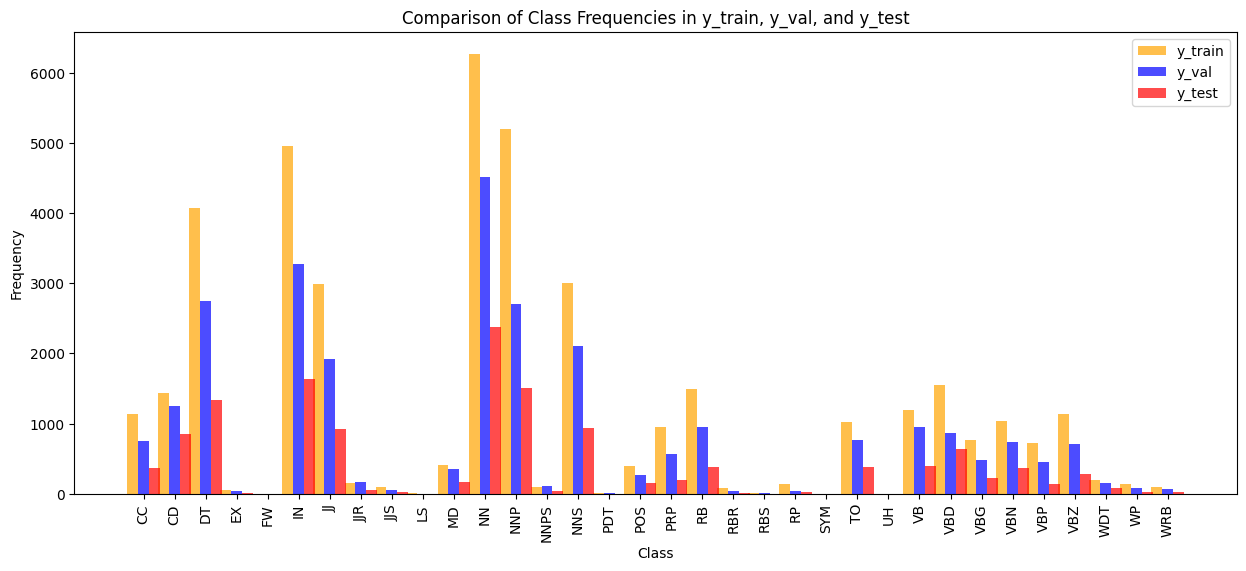

In [47]:
# Flatten the tensors and filter tokens as per your criteria
y_val_flatten_tokens = [labels_vocabulary[int(token)] for token in y_val.flatten()
                        if (int(token) != 0) & (int(token) in labels_vocabulary) & (labels_vocabulary[int(token)].isalnum())]
y_test_flatten_tokens = [labels_vocabulary[int(token)] for token in y_test.flatten()
                         if (int(token) != 0) & (int(token) in labels_vocabulary) & (labels_vocabulary[int(token)].isalnum())]
y_train_flatten_tokens = [labels_vocabulary[int(token)] for token in y_train.flatten()
                         if (int(token) != 0) & (int(token) in labels_vocabulary) & (labels_vocabulary[int(token)].isalnum())]

# Count frequencies of each class in both y_val and y_test
y_val_counts = Counter(y_val_flatten_tokens)
y_test_counts = Counter(y_test_flatten_tokens)
y_train_counts = Counter(y_train_flatten_tokens)


# Extract labels and their corresponding counts
labels = sorted(set(y_val_flatten_tokens + y_test_flatten_tokens + y_train_flatten_tokens))
y_val_freq = [y_val_counts[label] for label in labels]
y_test_freq = [y_test_counts[label] for label in labels]
y_train_freq = [y_train_counts[label] for label in labels]

# X locations for the groups
index = np.arange(len(labels))

# Plotting
plt.figure(figsize=(15, 6))
bar_width = 0.35
plt.bar(index - bar_width, y_train_freq, bar_width, color='orange', alpha=0.7, label='y_train')
plt.bar(index, y_val_freq, bar_width, color='blue', alpha=0.7, label='y_val')
plt.bar(index + bar_width, y_test_freq, bar_width, color='red', alpha=0.7, label='y_test')

plt.xticks(index, labels, rotation='vertical')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Comparison of Class Frequencies in y_train, y_val, and y_test')
plt.legend()

plt.show()

In [48]:
def analyze_errors(model: nn.Module, x: np.array, y:np.array, pad_token_idx: int = 0):
    all_errors = []
    total_predictions = 0

    for idx in range(len(x)):
        pred_pos_tags = infer(model, x[idx], device).cpu()
        target_pos_tags: torch.Tensor = y[idx].cpu()

        # Filter out padding
        non_padding_mask = target_pos_tags != pad_token_idx
        pred_pos_tags_no_padding = pred_pos_tags[non_padding_mask]
        target_pos_tags_no_padding = target_pos_tags[non_padding_mask]

        # Update total predictions
        total_predictions += len(target_pos_tags_no_padding)

        # Accumulate errors
        for target_tag, pred_tag in zip(target_pos_tags_no_padding, pred_pos_tags_no_padding):
            if target_tag != pred_tag:
                all_errors.append((labels_vocabulary[target_tag.item()], labels_vocabulary[pred_tag.item()]))

    return Counter(all_errors), total_predictions

val_errors, val_total = analyze_errors(best_model, x_val, y_val)
test_errors, test_total = analyze_errors(best_model, x_test, y_test)

In [49]:
def display_error_percentages(error_counts, total_predictions, num_common=10):
    print(f"\nTop {num_common} Error Percentages:")
    for error, count in error_counts.most_common(num_common):
        percentage = (count / total_predictions) * 100
        print(f"{error}: {percentage:.2f}%")

display_error_percentages(val_errors, val_total)
display_error_percentages(test_errors, test_total)


Top 10 Error Percentages:
('NN', 'VBN'): 1.29%
('NNP', 'VBN'): 1.24%
('NNS', 'VBN'): 1.16%
('NNP', 'NN'): 0.98%
('NN', 'JJ'): 0.68%
('NNP', 'JJ'): 0.67%
('JJ', 'VBN'): 0.61%
('CD', 'VBN'): 0.52%
('VBD', 'VBN'): 0.37%
('VBG', 'VBN'): 0.36%

Top 10 Error Percentages:
('NNP', 'VBN'): 1.81%
('NN', 'VBN'): 1.54%
('NNS', 'VBN'): 0.92%
('CD', 'VBN'): 0.86%
('NN', 'JJ'): 0.86%
('NNP', 'JJ'): 0.80%
('NNP', 'NN'): 0.73%
('JJ', 'VBN'): 0.52%
('VBD', 'VBN'): 0.48%
('CD', 'JJ'): 0.23%


In [50]:
def compare_error_percentages(val_errors, val_total, test_errors, test_total, num_common=10):
    print(f"\nComparison of Top {num_common} Errors (Validation vs Test):")
    common_errors = set([error for error, _ in val_errors.most_common(num_common)] +
                        [error for error, _ in test_errors.most_common(num_common)])

    for error in common_errors:
        val_percentage = (val_errors[error] / val_total) * 100
        test_percentage = (test_errors[error] / test_total) * 100
        print(f"{error} - Validation: {val_percentage:.2f}%, Test: {test_percentage:.2f}%")

compare_error_percentages(val_errors, val_total, test_errors, test_total)


Comparison of Top 10 Errors (Validation vs Test):
('VBD', 'VBN') - Validation: 0.37%, Test: 0.48%
('VBG', 'VBN') - Validation: 0.36%, Test: 0.22%
('NNP', 'NN') - Validation: 0.98%, Test: 0.73%
('NN', 'VBN') - Validation: 1.29%, Test: 1.54%
('NN', 'JJ') - Validation: 0.68%, Test: 0.86%
('NNP', 'VBN') - Validation: 1.24%, Test: 1.81%
('NNP', 'JJ') - Validation: 0.67%, Test: 0.80%
('NNS', 'VBN') - Validation: 1.16%, Test: 0.92%
('JJ', 'VBN') - Validation: 0.61%, Test: 0.52%
('CD', 'VBN') - Validation: 0.52%, Test: 0.86%
('CD', 'JJ') - Validation: 0.34%, Test: 0.23%


## What is the reason for the higher f1-score on the test set compared to the one observed on the validation set?
This can happen due to several reasons:
1. Data Distribution Differences: If the validation and test sets are not sampled from the same distribution or if they have different characteristics, the model might perform differently on these sets. This is especially true if the test set is somehow easier for the model to predict, or more representative of the data the model was trained on.
2. Overfitting to Validation Set: If you use the validation set extensively for hyperparameter tuning or model selection, there's a risk of overfitting to the validation set. This means the model is tuned specifically to perform well on the validation data, which might not generalize as well to the test set (or any unseen data).
3. Size of the Datasets: If the validation set is much smaller than the test set, the evaluation on the validation set might be less reliable due to higher variance in the performance measure. This can lead to situations where the model appears to perform worse on the validation set simply due to the statistical noise inherent in a smaller sample size.
4. Random Variation: Especially in cases where datasets are small, random variation can lead to differences in performance metrics. This is more pronounced in metrics like F1-score, which can be sensitive to the balance between precision and recall.
5. Model Instability: If the model is highly sensitive to the input data (which can happen with complex models like deep neural networks), small differences in the data distribution between the validation and test sets can lead to significant differences in performance.
6. Data Leakage: If there is some form of data leakage in the test set (but not in the validation set), the model might perform artificially well on the test set. Data leakage refers to a situation where information that should not be available during the training process inadvertently influences the model.
It's important to ensure that both validation and test sets are representative of the real-world data the model is expected to encounter, and to be cautious about over-tuning models based on validation set performance. Regular checks for data consistency and distribution similarity can help mitigate some of these issues.

# Error Analysis Report

## Overview
The analysis of the model's performance on the test and validation sets reveals insightful patterns and discrepancies in error rates. By focusing on the top 10 error percentages and their comparisons, we gain a clearer understanding of the model's strengths and weaknesses.

## Common Error Patterns
### Misclassification of Nouns (NN, NNP, NNS) as Verbs (VBN) and Adjectives (JJ):
- This error type is prevalent in both sets, with NN to VBN being the most frequent error in validation and NNP to VBN in the test set.
- The confusion between nouns and past participles (VBN) suggests a challenge in contextual understanding, especially in differentiating between nominalized verbs and their noun counterparts.

### Misclassification of CD (Cardinal Numbers):
- Notably, CD to VBN and CD to JJ are common errors, indicating difficulty in distinguishing numbers from verbs and adjectives.

### Verb Confusions (VBG to VBN, VBD to VBN):
- These errors suggest challenges in differentiating verb tenses and forms.

## Correlation with Class Frequency
The correlations between class frequency and performance metrics (precision, recall, F1-score) are relatively low. This suggests that class frequency is not a major determinant of these errors, pointing towards other factors such as contextual complexity or inherent model limitations.

## Proposed Solutions
### Contextual Enhancement:
- Improve the model's understanding of context. Techniques like contextual embedding (e.g., BERT-based models) can be more effective in capturing the nuanced usage of words in different contexts.
- Increasing the depth of the LSTM layers or experimenting with attention mechanisms might help the model capture more complex dependencies.

### Data Augmentation:
- Augmenting the training data with more examples of commonly confused pairs (like NN/VBN, CD/JJ) might help the model learn to distinguish these better.
- Using synonym augmentation or back-translation could introduce more varied sentence structures, aiding in better generalization.

### Class Imbalance Mitigation:
- Address potential class imbalances, even though the correlation is low. Techniques such as oversampling rare classes or using class-weighted loss functions might be beneficial.

### Error Analysis and Manual Review:
- Conduct a thorough qualitative analysis of the errors. Manually reviewing misclassified instances can provide insights that are not evident from quantitative analysis alone.
- Custom rules or post-processing steps could be introduced to handle specific, identifiable error patterns.

### Model Experimentation:
- Experiment with different model architectures (e.g., transformers, GRUs) or ensemble methods to see if they offer improved performance on these error types.

### Hyperparameter Tuning:
- Fine-tune hyperparameters such as learning rate, batch size, and dropout rates to optimize the model's performance.

## Conclusion
The model demonstrates a notable proficiency in tagging parts of speech but struggles with specific confusions, particularly in differentiating between nouns, verbs, and adjectives. Addressing these issues through a combination of data, model architecture, and contextual understanding enhancements could lead to significant improvements in the model's performance.


# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves to Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyperparameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

# The End